![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB


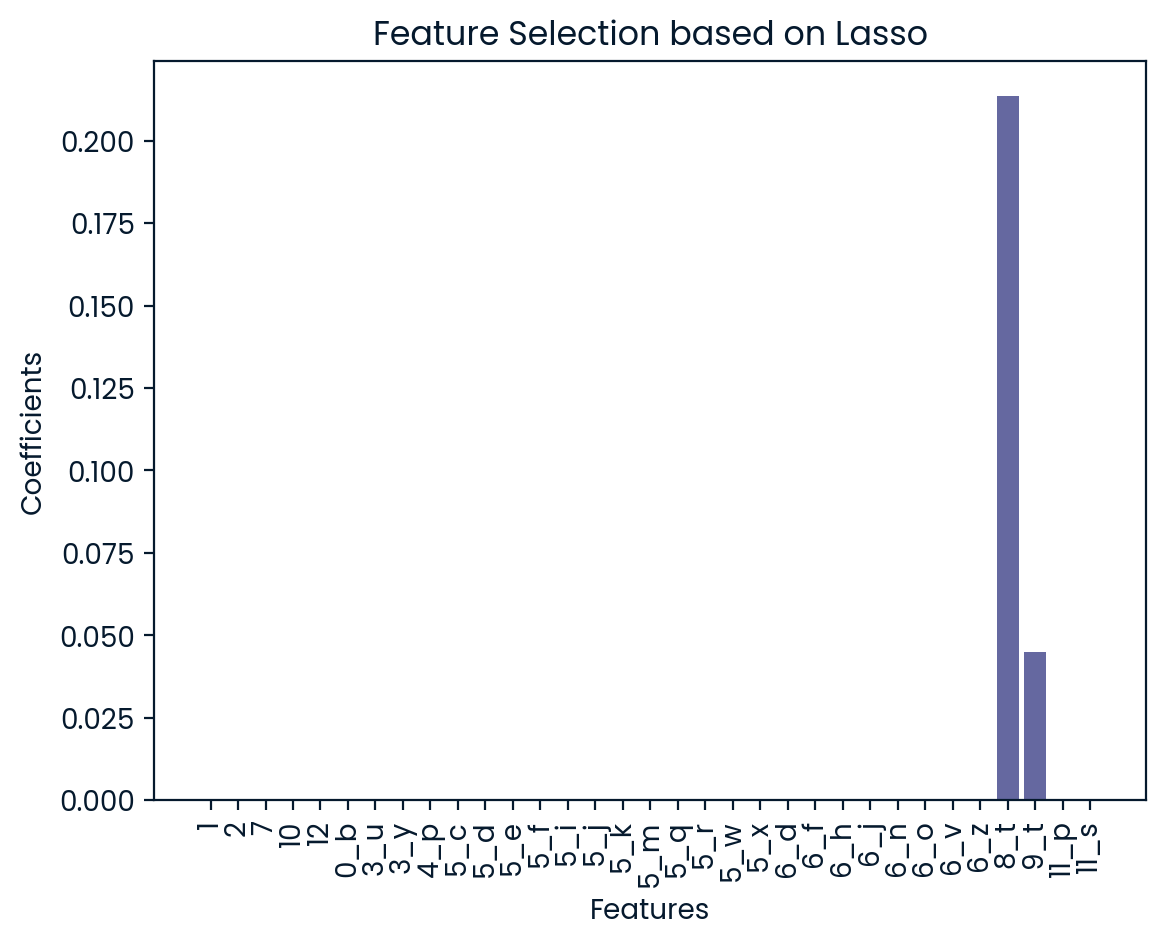

Logistic Regression Classifier best score on training: 0.8301697530864197
Logistic Regression Classifier best training parametres: {'C': 0.05357894736842105}
SVM Classifier best score on training: 0.8362911522633745
SVM Classifier best training parametres: {'C': 0.1, 'gamma': 0.01}
Decision Tree Classifier best score on training: 0.8362911522633745
Decision Tree Classifier best training parametres: {'max_depth': 3, 'min_samples_leaf': 0.04}
 Logistic Regression Classifier
 Accuracy on test set: 0.913

Classification Report:
              precision    recall  f1-score   support

           0      0.990     0.852     0.916       115
           1      0.843     0.989     0.910        92

    accuracy                          0.913       207
   macro avg      0.916     0.921     0.913       207
weighted avg      0.924     0.913     0.913       207

Confusion Matrix:
[[98 17]
 [ 1 91]]

 SVM Classifier
 Accuracy on test set: 0.913

Classification Report:
              precision    recall  f

In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

# Check data
cc_apps.info()
cc_apps.describe()

## Preprocessing
# Transform target variable to 0-1 values and remove from features dataframe.
cc_apps[13]= cc_apps[13].apply(lambda x: 1 if x=="+" else 0)
y = cc_apps[13]
features = cc_apps.drop(13, axis = 1)

# Replace "?" by np.NaN
features = features.replace("?", np.NaN)
features

# Transform datatype column 1
features[1] = features[1].astype(float)

# Separate Categorical from Numerical features.
cat_features = [0,3,4,5,6,8,9,11]
num_features = features.drop(columns = cat_features)

# Loop through categorical features to replace double letters and replace np.NaN by most-frequent/ mode
for col in cat_features:
    # Replace double letters like "aa" -> "a"
    features[col] = features[col].apply(
        lambda x: x[0] if isinstance(x, str) and len(x) == 2 and x[0] == x[1] else x
    )
    
    # Replace NaN values with the most frequent (mode) value
    if features[col].isnull().any():
        mode_value = features[col].mode(dropna=True)
        if not mode_value.empty:
            features[col].fillna(mode_value[0], inplace=True)

# Get mean value of column 1 and use it to replace NaN values and check.
mean_1 = features[1].mean()
features[1]= features[1].replace(np.NaN, mean_1)
features.isna().sum()

# Get dummies for all categorical features with pd.get_dummies() and pd.concat()
dummies = pd.get_dummies(features[[0,3,4,5,6,8,9,11]], drop_first = True)
features_dummies = pd.concat([features, dummies], axis = 1)
X = features_dummies.drop([0,3,4,5,6,8,9,11], axis = 1)
X = X.copy()
X.columns = X.columns.astype(str)

# Split data and stratify target variable
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = seed)

# Scale training and test data with StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Feature selection with Lasso
lasso = Lasso(alpha = 0.1)
lasso_coefs = np.abs(lasso.fit(X_train_scaled, y_train).coef_)
names = X_train_scaled_df.columns
plt.bar(names, lasso_coefs)
plt.xlabel("Features")
plt.xticks(rotation = 90)
plt.ylabel("Coefficients")
plt.title("Feature Selection based on Lasso")
plt.show()
selected_features = lasso_coefs > 0
X_train_selected = X_train_scaled_df.iloc[:,selected_features]
X_test_selected = X_test_scaled_df.iloc[:,selected_features]

## Models: Logistic Regression Classifier, SVM Classifier and Decision Tree Classifier.
# Logistic Regression Classifier fit, best score and best parameters.
logreg = LogisticRegression()
param_grid = {"C": np.linspace(0.001, 1, 20)}
logreg_cv = GridSearchCV(logreg, param_grid, cv = 6)
logreg_cv.fit(X_train_selected, y_train)
logreg_best_score = logreg_cv.best_score_
logreg_best_params = logreg_cv.best_params_
print("Logistic Regression Classifier best score on training:", logreg_best_score)
print("Logistic Regression Classifier best training parametres:", logreg_best_params)

# SVM Classifier fit, best score and best parameters
svc = SVC()
param_grid = {"C": [0.1, 1, 10],
             "gamma": [0.0001, 0.001, 0.01]}
svc_cv = GridSearchCV(svc, param_grid, cv = 6)
svc_cv.fit(X_train_selected, y_train)
svc_best_score = svc_cv.best_score_
svc_best_params = svc_cv.best_params_
print("SVM Classifier best score on training:", svc_best_score)
print("SVM Classifier best training parametres:", svc_best_params)

# Decision Tree Classifier fit, best score and best parameters
dtc = DecisionTreeClassifier(random_state= seed)
param_grid = {"max_depth": [3,4,5,6],
             "min_samples_leaf": [0.04, 0.06, 0.08]}
dtc_cv = GridSearchCV(dtc, param_grid, cv = 6)
dtc_cv.fit(X_train_selected, y_train)
dtc_best_score = dtc_cv.best_score_
dtc_best_params = dtc_cv.best_params_
print("Decision Tree Classifier best score on training:", dtc_best_score)
print("Decision Tree Classifier best training parametres:", dtc_best_params)

# Evaluation: accuracy score on test, classification report and confusion matrix

models = {"Logistic Regression Classifier": logreg_cv,
         "SVM Classifier": svc_cv,
         "Decision Tree Classifier": dtc_cv}
for name, model in models.items():
    y_pred = model.predict(X_test_selected)
    test_accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, digits=3)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("=" * 60)
    print(f" {name}")
    print(f" Accuracy on test set: {test_accuracy:.3f}")
    print("\nClassification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print()

# Evaluation: Best Test score (taking into account test_accuracy only and going for a simpler model) is the LogisticRegression Classifier (0.913); however, if we took into account the amount of false positives (predicted "+" or granted credit cards when actually rejected or "-"), the Decision Tree Classifier has a lower test accuracy (still higher than 0.75) but a lower false rate or higher precision and therefore, it is a better model. 
# Still, other issues -ethical, social- should be taken into account. The model with better precision (better for the bank) would be turning down credit cards for people who are creditworthy by looking at the amount of false negatives, so it would be somewhat discriminating. 

y_pred = dtc_cv.predict(X_test_selected)
test_accuracy_dtc = accuracy_score(y_test, y_pred)
best_score = test_accuracy_dtc
print(best_score)



